In [1]:
%matplotlib inline
import keras
import numpy as np 
import spacy
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
nlp = spacy.load('en_vectors_web_lg')

## Dataset can be downloaded from [here](https://www.kaggle.com/laowingkin/amazon-fine-food-review-sentiment-analysis/data)

In [3]:
connection = sqlite3.connect('../data/fine_foods_reviews.sqlite')

Let's load data with score other than 3, and label rest as `positive` or `negative`

In [19]:
import re

messages = pd.read_sql_query("""
SELECT Score, lower(Text) as Summary
FROM Reviews
WHERE Score != 3
ORDER BY RANDOM()
LIMIT 5000
""", connection)

def clear_text(text):
    only_alpha_regex = re.compile(r'[^\w+ ]')
    return only_alpha_regex.sub('', text)
    

messages['Label'] = messages.apply(lambda x: int(x['Score'] > 3), axis=1)
messages['Summary'] = messages['Summary'].apply(clear_text)
messages.head()

,Score,Summary,Label
0,4,this is a great tasting item i like having the...,1
1,4,expiration date is on may 2012so drink fast bu...,1
2,5,my dog loves any dingo products she loves them...,1
3,5,the 45 oz gel paste goes a long way colour doe...,1
4,5,what can you say these fireballs were just li...,1


### data analysis

Text(0,0.5,'Frequency')

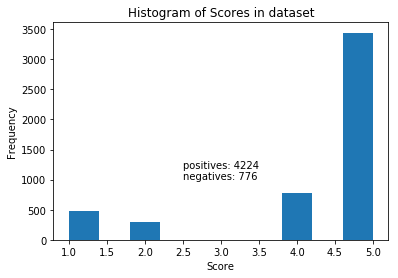

In [20]:
plt.hist(messages.Score)
plt.title('Histogram of Scores in dataset')
plt.text(2.5, 1000, 'positives: {}\nnegatives: {}'.format(*messages.Label.value_counts().values))
plt.xlabel('Score')
plt.ylabel('Frequency')

### Models

In [21]:
from sklearn.cross_validation import train_test_split

X = np.array([nlp(m).vector for m in messages['Summary']])
y = messages.Label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [25]:
from sklearn.model_selection import cross_val_score
from plot_helpers import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

def check_model(name, model):
    fitted_model = model.fit(X_train, y_train)
    y_pred = fitted_model.predict(X_test)
    classes = ['Negative', 'Positive']
    print("Classification report for {}\n".format(name))
    print(classification_report(y_test, y_pred, target_names=classes))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes)

    scores = cross_val_score(model, X, y, cv=4, n_jobs=1, scoring='roc_auc')
    print("cross-validated ROC AUC for %s: %0.4f (+/- %0.4f)" % (name, scores.mean(), scores.std() * 2))

Classification report for Dummy - most frequent class

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00       218
   Positive       0.83      1.00      0.90      1032

avg / total       0.68      0.83      0.75      1250

cross-validated ROC AUC for Dummy - most frequent class: 0.5000 (+/- 0.0000)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


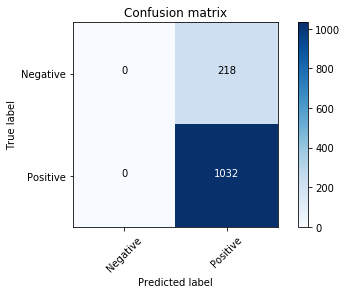

In [26]:
from sklearn.dummy import DummyClassifier
check_model('Dummy - most frequent class', DummyClassifier('most_frequent'))

Classification report for KNeighbours

             precision    recall  f1-score   support

   Negative       0.56      0.15      0.24       218
   Positive       0.84      0.97      0.91      1032

avg / total       0.79      0.83      0.79      1250

cross-validated ROC AUC for KNeighbours: 0.7160 (+/- 0.0330)


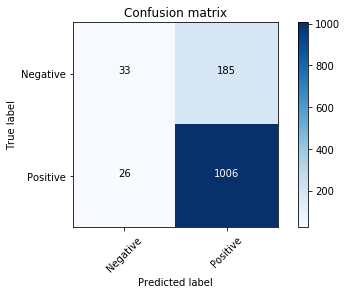

In [27]:
from sklearn.neighbors import KNeighborsClassifier
check_model('KNeighbours', KNeighborsClassifier(5))

Classification report for Linear SVC

             precision    recall  f1-score   support

   Negative       0.00      0.00      0.00       218
   Positive       0.83      1.00      0.90      1032

avg / total       0.68      0.83      0.75      1250



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cross-validated ROC AUC for Linear SVC: 0.8991 (+/- 0.0135)


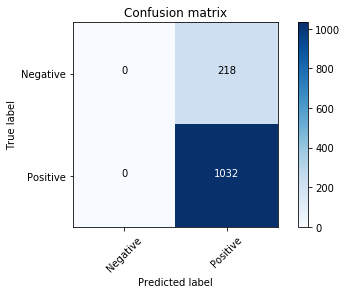

In [28]:
from sklearn.svm import SVC
check_model('Linear SVC', SVC(kernel="linear", C=0.025))

Classification report for SVC

             precision    recall  f1-score   support

   Negative       0.83      0.28      0.42       200
   Positive       0.88      0.99      0.93      1050

avg / total       0.87      0.88      0.85      1250

cross-validated ROC AUC for SVC: 0.8752 (+/- 0.0457)


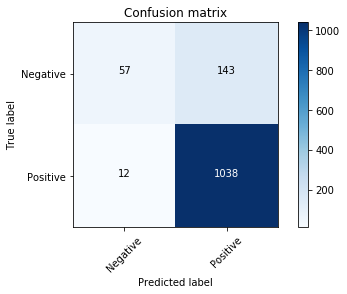

In [13]:
from sklearn.svm import SVC
check_model('SVC', SVC(gamma=2, C=1))

Classification report for DecisionTreeClassifier

             precision    recall  f1-score   support

   Negative       0.35      0.37      0.36       218
   Positive       0.87      0.86      0.86      1032

avg / total       0.78      0.77      0.77      1250

cross-validated ROC AUC for DecisionTreeClassifier: 0.6163 (+/- 0.0307)


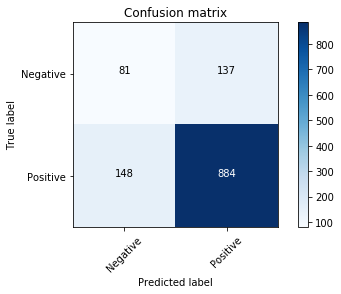

In [29]:
from sklearn.tree import DecisionTreeClassifier
check_model('DecisionTreeClassifier', DecisionTreeClassifier())

Classification report for RandomForest

             precision    recall  f1-score   support

   Negative       0.49      0.19      0.27       218
   Positive       0.85      0.96      0.90      1032

avg / total       0.79      0.82      0.79      1250

cross-validated ROC AUC for RandomForest: 0.7462 (+/- 0.0193)


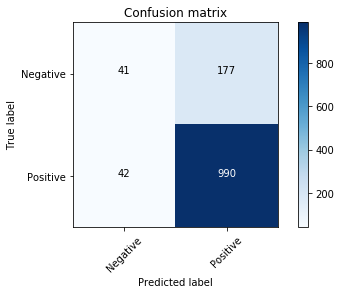

In [30]:
from sklearn.ensemble import RandomForestClassifier
check_model('RandomForest', RandomForestClassifier())

Classification report for NeuralNet

             precision    recall  f1-score   support

   Negative       0.74      0.57      0.64       218
   Positive       0.91      0.96      0.94      1032

avg / total       0.88      0.89      0.88      1250

cross-validated ROC AUC for NeuralNet: 0.9050 (+/- 0.0179)


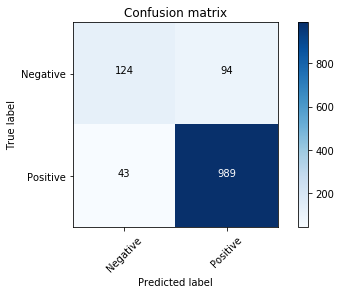

In [31]:
from sklearn.neural_network import MLPClassifier
check_model('NeuralNet', MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500))

Classification report for NaiveBayes

             precision    recall  f1-score   support

   Negative       0.31      0.66      0.42       218
   Positive       0.91      0.68      0.78      1032

avg / total       0.80      0.68      0.72      1250

cross-validated ROC AUC for NaiveBayes: 0.7863 (+/- 0.0317)


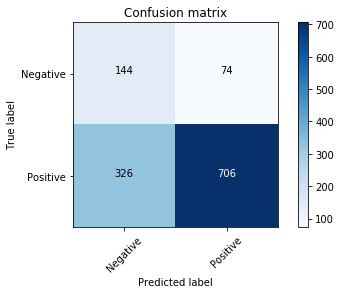

In [32]:
from sklearn.naive_bayes import GaussianNB
check_model('NaiveBayes', GaussianNB())

Classification report for AdaBoostClassifier

             precision    recall  f1-score   support

   Negative       0.65      0.40      0.50       218
   Positive       0.88      0.95      0.92      1032

avg / total       0.84      0.86      0.84      1250

cross-validated ROC AUC for AdaBoostClassifier: 0.8476 (+/- 0.0127)


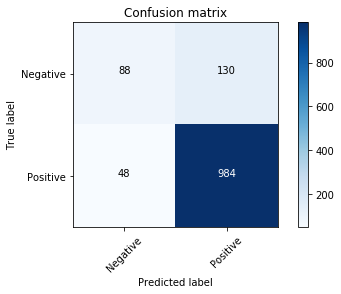

In [33]:
from sklearn.ensemble import AdaBoostClassifier
check_model('AdaBoostClassifier', AdaBoostClassifier())

Classification report for QuadraticDiscriminantAnalysis

             precision    recall  f1-score   support

   Negative       0.35      0.06      0.10       218
   Positive       0.83      0.98      0.90      1032

avg / total       0.75      0.82      0.76      1250

cross-validated ROC AUC for QuadraticDiscriminantAnalysis: 0.6159 (+/- 0.0422)


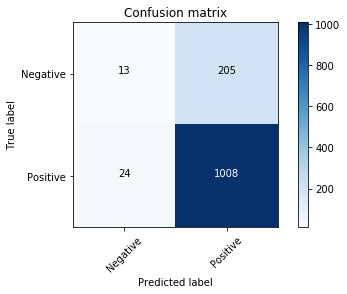

In [34]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
check_model('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis())

Classification report for LogisticRegression

             precision    recall  f1-score   support

   Negative       0.69      0.58      0.63       218
   Positive       0.91      0.94      0.93      1032

avg / total       0.88      0.88      0.88      1250

cross-validated ROC AUC for LogisticRegression: 0.8876 (+/- 0.0213)


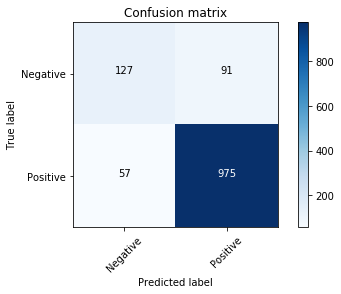

In [35]:
from sklearn.linear_model import LogisticRegression
check_model('LogisticRegression', LogisticRegression(C=1e5))

Classification report for GradientBoostingClassifier

             precision    recall  f1-score   support

   Negative       0.78      0.37      0.50       218
   Positive       0.88      0.98      0.93      1032

avg / total       0.86      0.87      0.85      1250

cross-validated ROC AUC for GradientBoostingClassifier: 0.8819 (+/- 0.0236)


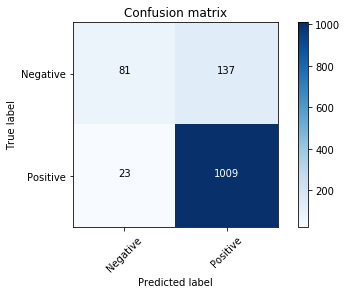

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
check_model('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=500, max_depth=2))